In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils.process import process_gt_json, process_result_csv, sort_by_confidence
from utils.metrics import IoU, get_mAP
from utils.visualize import draw_one_bbox

### load pred & gt

In [3]:
GT_JSON = '/opt/ml/detection/dataset/split_valid.json' #gt json
PRED_CSV = '/opt/ml/detection/mmdetection/work_dirs/swin_transformer/valid_best_bbox_mAP_50_epoch_39_ttasplit_softnms.csv' # predict csv. inference를 split_valid.json으로하면 됩니다!
gt_array = process_gt_json(GT_JSON)
pred_array = process_result_csv(PRED_CSV)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### Caculate mAP

In [4]:
mAP, average_precisions = get_mAP(pred_array, gt_array, verbose=True)

Number of files in annotations: 988
Number of files in predictions: 987
Unique classes: 10
Detections length: 987
Annotations length: 988
Battery                        | 0.818217 |      32
Clothing                       | 0.617276 |      94
General trash                  | 0.333769 |     793
Glass                          | 0.678248 |     197
Metal                          | 0.529223 |     187
Paper                          | 0.503544 |    1271
Paper pack                     | 0.606225 |     179
Plastic                        | 0.472862 |     589
Plastic bag                    | 0.732749 |    1035
Styrofoam                      | 0.539750 |     252
mAP: 0.583186


### prediction 결과 계산

In [5]:
# 0: "General trash"
# 1: "Paper"
# 2: "Paper pack"
# 3: "Metal"
# 4: "Glass"
# 5: "Plastic"
# 6: "Styrofoam"
# 7: "Plastic bag"
# 8: "Battery"
# 9: "Clothing"

## 궁금한 category (name or index)
query_category = 'Plastic bag'

In [6]:
class_pred = sort_by_confidence(pred_array, query_category)

gt_inds = np.where(gt_array[:,1]==query_category)[0]
class_gt = gt_array[gt_inds]

In [7]:
IOU_THRESH = 0.5
predict_correct = np.zeros(len(class_pred))
gt_correct = np.zeros(len(class_gt))

for pr_i, pr in enumerate(class_pred):
    file = pr[0]
    pr_box = pr[3:].astype(np.float64)
    for gt_i, gt in enumerate(class_gt):
        if gt_correct[gt_i] != 0 or gt[0] != file:
            continue
        gt_box = gt[2:].astype(np.float64)
        if IoU(pr_box, gt_box) > IOU_THRESH:
            gt_correct[gt_i] = 1
            predict_correct[pr_i] = 1
            break

Plastic bag
mAP :0.7327486567251794
gt correct 84.15458937198068%
pr correct 13.998714239794277%


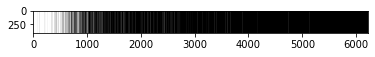

In [8]:
print(query_category)
print(f'mAP :{average_precisions[query_category][0]}')
print(f'gt correct {int(gt_correct.sum())/len(gt_correct)*100}%')
print(f'pr correct {int(predict_correct.sum())/len(predict_correct)*100}%')
plt.imshow(np.stack([predict_correct]*(len(predict_correct)//15), 0), cmap='gray')
plt.show()


### 찾지 못한 bbox visualize

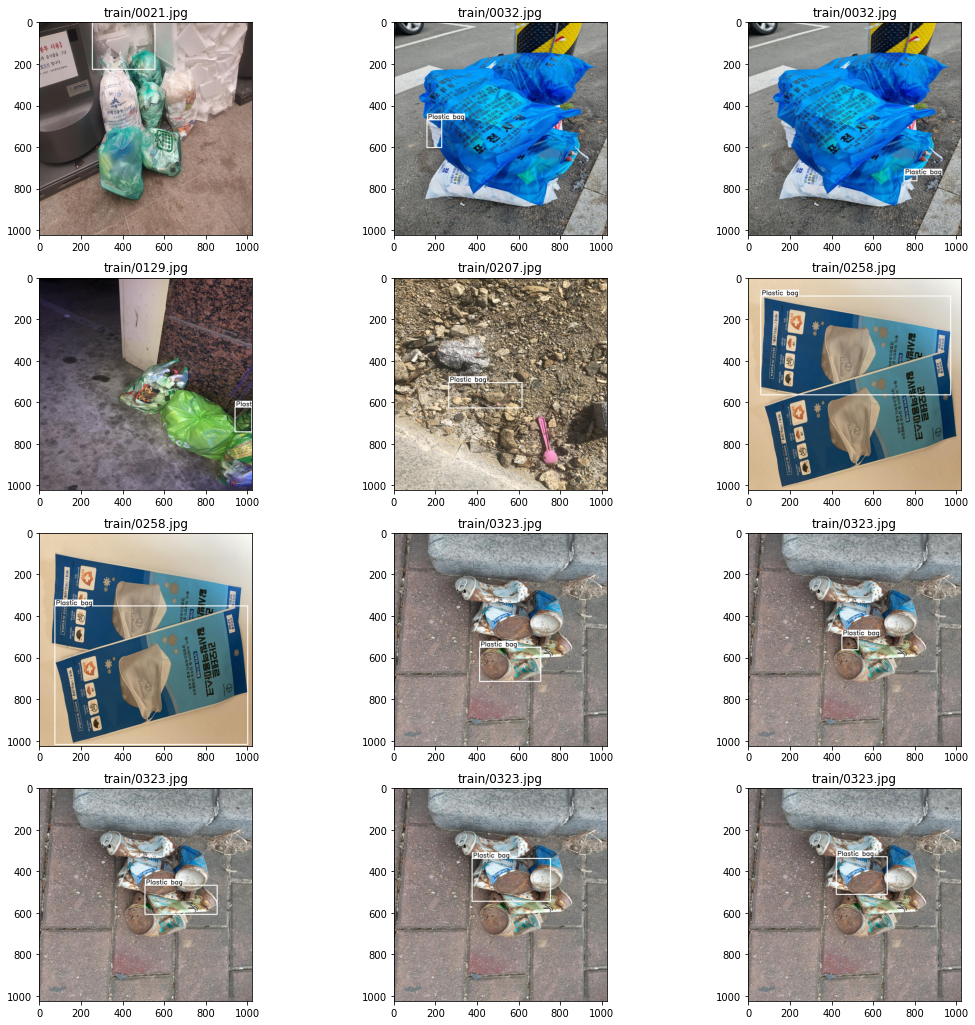

KeyboardInterrupt: Interrupted by user

In [9]:
from IPython import display

image_num = 3
grid_W, grid_H = 3, 4

idx = 0
inds = np.where(gt_correct==0)[0]
L = len(inds)
while(idx < L):    
    fig, axes = plt.subplots(grid_H, grid_W, figsize=(18,18))

    for i in range(grid_W*grid_H):
        if idx+i >=L:
            break
        img = draw_one_bbox(class_gt[inds[idx+i]])
        img = np.array(img)
        x = i//grid_W
        y = i%grid_W
        axes[x][y].imshow(img)
        axes[x][y].set_title(f'{class_gt[inds[idx+i]][0]}')
        
    plt.show()
    input()

    display.clear_output(wait=True)
    display.display(plt.gcf())
    idx += grid_W*grid_H
    plt.close()